<a href="https://colab.research.google.com/github/R0bk/ml_replications/blob/main/notes/Stochastic_Differential_Equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stochastic Differential Equations

Stochastic differential equations (SDE) are differential equations that represent a continous time stochastic process. We often use the Wiener process, also refered to as Brownian motion to represent this process. The general form a SDE is found in appears as: $\\[10pt]$ 

$dX(t)=f(X,X(t))dt+g(X,X(t))dw(t) \tag{1}$ $\\[10pt]$ 

Where $f(·)$ is the drift term and $g(·)$ is the diffusion term. In a Lipschitz Continuious SDE, one with unique soloutions $f(·)$ determines $𝔼(x(t))$ and $g(·)$ characterises the variance. The Lipschitz Continuity of this form of SDE is given by the following: $\\[10pt]$ 

Given an initial point $X(0) = x(0)$ $\\[10pt]$ 

$|f(t,x)-f(t,y)|^2+|g(t,x)-g(t,y)^2|<K|x-y|^2 \tag{2}$ $\\[10pt]$

$|f(t,x)|^2+|g(t,x)|^2<K(1+|x|^2) \tag{3}$ $\\[10pt]$ 

Where $x, y$ are any two values and $K$ is a constant. in $(1)$ This essentially limits the change in $f(·)$ and $g(·)$ between to points to be no greater than a constant by the difference between the points. $(2)$ Does a similar job, limiting the growth in $x$ across over the entire function. Essentially these two constraints ensure resonable, non exploding gradients. $\\[10pt]$ 




For the special case of geometric brownian motion where $f(·)=μ·x$ and $g(·)=σ·x$ we can write the SDE as: $\\[10pt]$

$dX(t)=μX(t)\;dt+σX(t)dw(t) \tag{4}$ $\\[10pt]$ 

This has the unique soloution: $\\[10pt]$ 

$X(t)=X(0)\;exp((μ-\frac{σ^2}{2})t+σw(t)) \tag{5}$ $\\[10pt]$ 

To calculate samples at discrete points we can use the definition of the Wiener process $w_t-w_s=w_{t-s}-w_0$ where $0<s<t \in ℝ$. With the knowledge $w_0=0$ we then know $w_t-w_s=w_{t-s}$ where $w_{t-s}=𝓝(0,t-s)$. To calculate a sample path we can then cumulatively sum these $w_{t-s}$ as we progress.

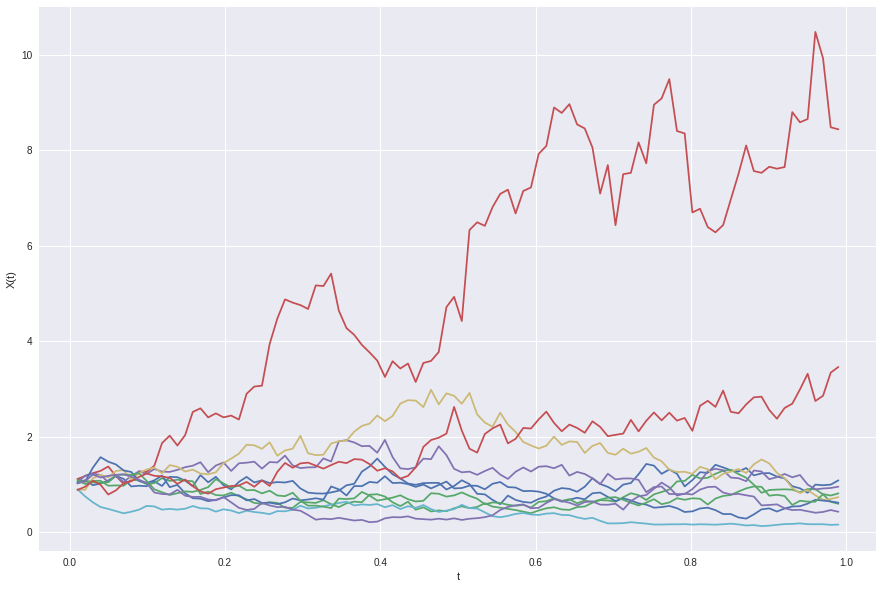

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')


# Initial params
X0 = 1
mu = 1
sigma = 1
N = int(10e1)
dt = 1./(N+1)
n_paths = 10

x = np.broadcast_to(np.arange(dt, 1, dt), (n_paths, N))
B = np.cumsum(np.random.randn(n_paths, N) * np.sqrt(dt), axis=1)
y = X0 * np.exp((mu-sigma**2/2)*x + sigma*B)


plt.figure(figsize=(15, 10))
plt.xlabel("t")
plt.ylabel('X(t)')
plt.plot(x.T,y.T)
plt.show()

We can also sample many paths and show that they reach a distribution that increases variance over time.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


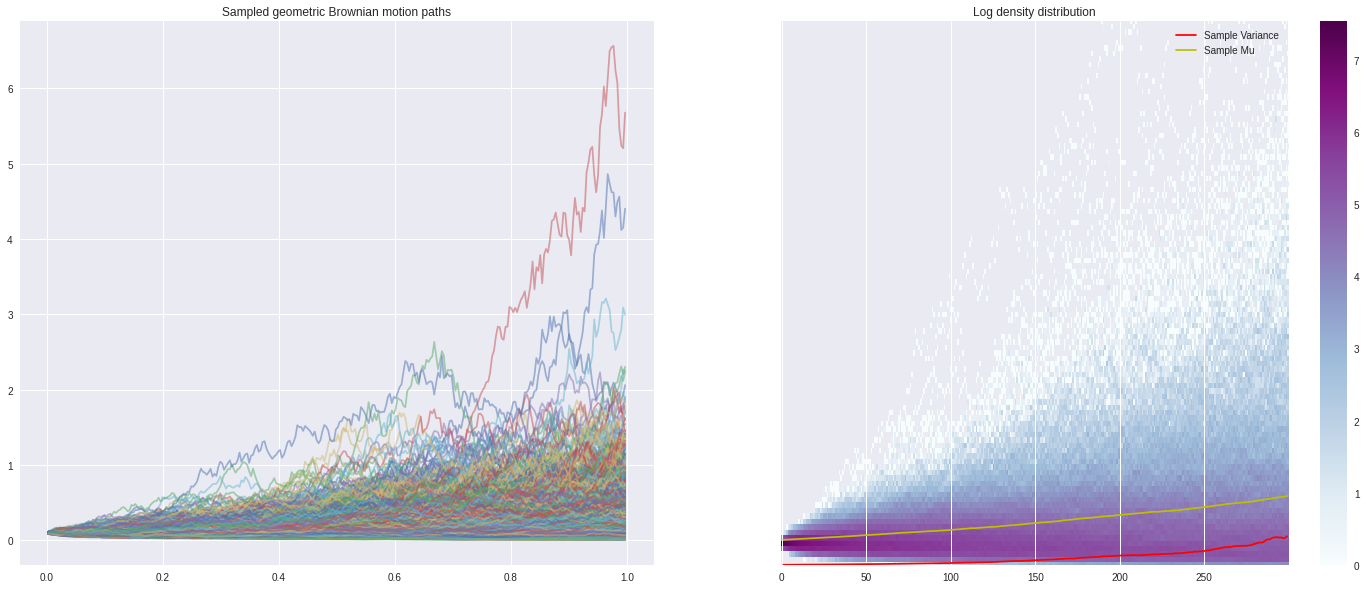

In [ ]:
# Initial params
X0 = 0.1
mu = 1
sigma = 1
N = int(30e1)
dt = 1./(N+1)
n_paths = 2000
n_bins = N

x = np.broadcast_to(np.arange(dt, 1, dt), (n_paths, N))
B = np.cumsum(np.random.randn(n_paths, N) * np.sqrt(dt), axis=1)
y = X0 * np.exp((mu-sigma**2/2)*x + sigma*B)

H = np.array(list(map(lambda x: np.histogram(x, range=(np.min(y), np.max(y)), bins=n_bins)[0], y.T)))
sam_var = np.var(y.T, axis=1)
sam_mu = np.mean(y.T, axis=1)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
ax1.set_title('Sampled geometric Brownian motion paths')
ax1.plot(x.T,y.T, alpha=0.5)
ax2.set_title('Log density distribution')
ax2.axes.yaxis.set_visible(False)
img = ax2.imshow(np.log(H.T), interpolation='nearest', cmap=plt.cm.BuPu, aspect="auto")

# Plot mean and variance
ax2.plot(x[0]*n_bins, sam_var/np.max(y)*n_bins, color='r', label='Sample Variance')
ax2.plot(x[0]*n_bins, sam_mu/np.max(y)*n_bins, color='y', label='Sample Mu')

ax2.set_ylim(0,100)
h,l = ax2.get_legend_handles_labels()
ax2.legend(handles=h, labels=['Sample Variance', 'Sample Mu'])
cb = plt.colorbar(img)

For Geometric Brownian motion we can also show how the Lipschitz bounds look $for y=0$.

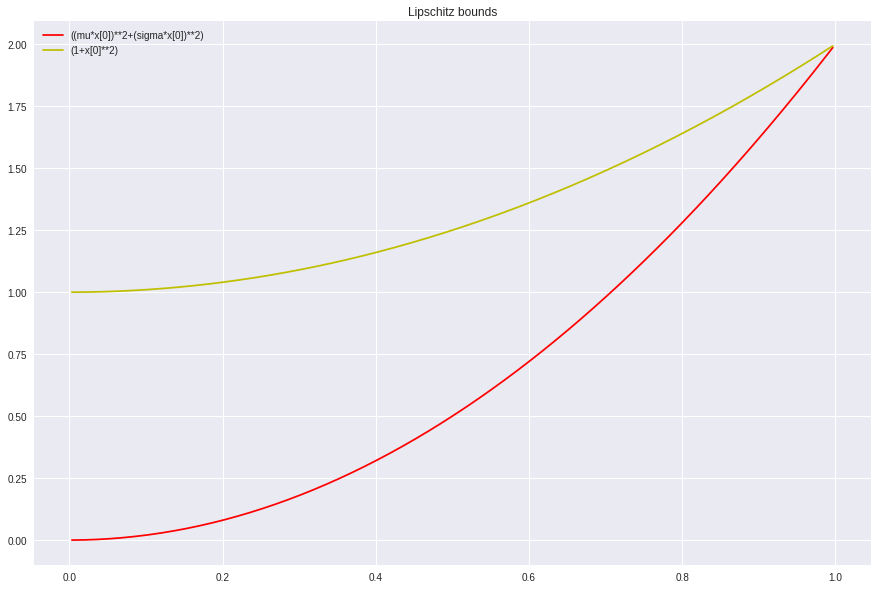

In [ ]:
# Initial params
mu = 1
sigma = 1
N = int(30e1)
dt = 1./(N+1)
n_bins = N

x = np.broadcast_to(np.arange(dt, 1, dt), (n_paths, N))

# Plotting
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.set_title('Lipschitz bounds')
ax1.plot(x[0], ((mu*x[0])**2+(sigma*x[0])**2), color='r', label='1')
ax1.plot(x[0], (1+x[0]**2), color='y', label='1')

h,l = ax1.get_legend_handles_labels()
ax1.legend(handles=h, labels=['((mu*x[0])**2+(sigma*x[0])**2)', '(1+x[0]**2)'])

Unfortunately not all SDEs are as easy to deal with as geometric Brownian motion and without a unique soloution we can't sample paths like above as easily. For this reason we have developed numerical estimation techniques.

# Numerical estimation

The most simplistic estimation method for SDEs is known as the Euler-Maruyama method. 

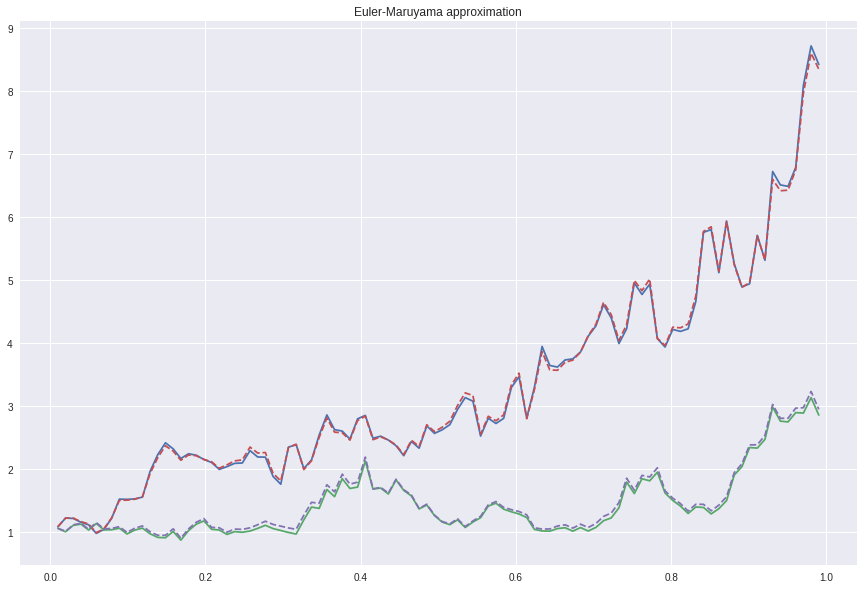

In [ ]:
# Initial params
X0 = 1
mu = 1
sigma = 1
N = int(10e1)
dt = 1./(N+1)
n_paths = 2

x = np.broadcast_to(np.arange(dt, 1, dt), (n_paths, N))
dB = np.random.randn(n_paths, N) * np.sqrt(dt)
B = np.cumsum(dB, axis=1)
y = X0 * np.exp((mu-sigma**2/2)*x + sigma*B)

# EM
em_x, em_X = np.zeros((n_paths, N)), X0
for j in range(N):
    em_X += mu*em_X*dt + sigma*em_X*dB[:,j]
    em_x[:,j] = em_X


fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.set_title('Euler-Maruyama approximation')
ax1.plot(x.T, y.T)
ax1.plot(x.T, em_x.T, ls='--')

### Example

Using gaussians for easy demonstration and conditional sampling

In [ ]:
import numpy as np

In [ ]:
n_dimensions = 2

In [ ]:
mu = np.random.rand(n_dimensions)
x = np.random.rand(n_dimensions, n_dimensions)
covar = np.dot(x, x.transpose())
print(f'mu:\n{mu}')
print(f'covar:\n{covar}')

mu:
[0.69732847 0.47030449]
covar:
[[1.26934065 0.60912778]
 [0.60912778 0.58273933]]


In [ ]:
def cond_sample(x, sample_on, condition_on, mu, covar):
    '''
    Returns a random sample of one gaussian e.g. x[0] conditional on another e.g. x[1]
    '''
    x_mu = mu[sample_on] + (covar[0, 1]/covar[condition_on, condition_on]) * (x[condition_on]-mu[condition_on])
    x_sigma = (covar[sample_on, sample_on] - covar[0, 1]**2/covar[condition_on, condition_on])**0.5
    x[sample_on] = x_mu + np.random.randn()*x_sigma
    return x

In [ ]:
T = 5000
x = np.random.rand(n_dimensions)
points = np.zeros((T*2+1, n_dimensions))
for t in range(T):
    '''
    We only take cond samples in order here, for true gibbs sampling we should
    randomly select the order to take them in
    '''
    points[t*2] = x
    x = cond_sample(x, 0, 1, mu, covar)
    points[t*2+1] = x
    x = cond_sample(x, 1, 0, mu, covar)
points[-1] = x
print(points)

[[0.12707204 0.76975606]
 [1.69430932 0.76975606]
 [1.69430932 1.30712781]
 ...
 [1.58487464 0.58093051]
 [0.3714197  0.58093051]
 [0.3714197  0.45683995]]


In [ ]:
from ipywidgets import IntSlider, interact, FloatSlider
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


@interact(t = IntSlider(min=1, max=T*2+1))
def aa_(t):
    xy_range = [*points.min(0), *points.max(0)]
    plt.figure(figsize = (15, 15))
    x, y = np.mgrid[xy_range[0]-0.5:xy_range[2]+0.5:.01, xy_range[1]-0.5:xy_range[3]+0.5:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, covar)
    plt.contourf(x, y, rv.pdf(pos))
    plt.scatter(points[:t,0], points[:t,1], s=2.5, c='#ff7f0e')
    plt.xlim(xy_range[0]-0.5, xy_range[2]+0.5)
    plt.ylim(xy_range[1]-0.5, xy_range[3]+0.5)


interactive(children=(IntSlider(value=1, description='t', max=10001, min=1), Output()), _dom_classes=('widget-…